<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-и-первичный-анализ-данных" data-toc-modified-id="Импорт-и-первичный-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт и первичный анализ данных</a></span></li><li><span><a href="#Выводы-по-анализу-данных" data-toc-modified-id="Выводы-по-анализу-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Выводы по анализу данных</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — сколько лет человек является клиентом банка
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата

Целевой признак
 - Exited — факт ухода клиента

In [1]:
#Импорт библиотек
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold

In [2]:
try:
    import pandas_profiling
except ImportError:
    ! pip install pandas_profiling
    import pandas_profiling

## Подготовка данных

### Импорт и первичный анализ данных

In [3]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [4]:
# Для комплексного анализа данных и чтобы ничего не забыть, воспользуемся pandas_profiling
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Выводы по анализу данных

 1. 7 столбцов - числовые, 7 - категориальные. Более подробно посмотрим при дальнейшем анализе
 2. Столбцы, которые не несут никакой информации и которые удалим из далнейшего рассмотрения:
    
    2.1. RowNumber - порядковый номер записи
    
    2.2. CustomerId  - порядковый номер клиента. Поле могло бы иметь какой-то смысл, если бы в id была зашифрована какая-то информация о клиенте. Но у нас такой информации нет. Поэтому, удалим
    
    2.3. Surname - можно предположить, что фамилия клиента никак не зависит от количества времени его пребывания клиентом банка
 
 3. По всем столбцам, кроме Tenure отсутствуют пропуски. В столбце Tenure пропуски в 9.1% данных. Что много.
 
 4. По столбцу Tenure 3,8% данных нули. То есть клиент является лиентов меньше года, и это нормально. По столбцу Balance 36% данных - нули. То есть на счету нет денег. Что тоже частая истуация. 
 
 5. Имеется корреляция между признаками Balance и NumOfProducts, что не очень хорошо, т.к. данные могут компенсировать друг на друга при влиянии на целевой показатель. Посмотрим на них повнимательнее дальше. Также есть взаимосвязь между целевым показателем и признаком Age, эту связь проанализируем в Дальнейшем  

## Исследование задачи

In [5]:
#1. Столбец Tenure. Посмотрим, если он не заполнен, какие значения у целевого столбца. Можно сказать, что  взаимосвязи 
# нет (корреляции тоже нет). Предлагается заполнить пропуски медианным значением.
print(data['Exited'][data['Tenure'].isnull()].value_counts().to_dict())
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

{0: 726, 1: 183}


In [6]:
drop_col = ['RowNumber', 'CustomerId', 'Surname']

#Сформируем итоговый список категориальных признаков и числовых. 
categorial = ['Geography', 'Gender' ]
numerical = ['Creditscore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','HasCrCard', 'IsActiveMember', 'EstimatedSalary']
target = ['Exited']

# к числовым будем относить и признаки, не имеющие нормального распределения и, строго говоря, являющиеся категориальными 
# (напр. - 'IsActiveMember')


In [7]:
#удалим ненужное
data.drop(drop_col, axis = 1, inplace = True)

In [8]:
#Так как все категориальные признаки имеют мало значений, то закодируем просто LabelEncoder, без регуляризации
le = OrdinalEncoder()
data[['Gender', 'Geography']] = le.fit_transform(data[['Gender', 'Geography']])

In [9]:
# Из графиков распределения видно, что  существует очень большой разброс между минимальным и максимальным
# значением значений "Balance" и "EstimatedSalary". "Balance" имеет нормальное распределение, "EstimatedSalary" - нет.
# Будем использовать MinMaxScaler. Он хорошо подходит и для нормального распределения, и для не нормального.

# ----- логично, перенес ниже------ 
#scaler = MinMaxScaler()
#data[["Balance", "EstimatedSalary"]] = scaler.fit_transform(data[["Balance", "EstimatedSalary"]])

In [10]:
features, target = data.drop("Exited", axis=1), data["Exited"] 

features_train, ft, target_train, tt = train_test_split(features, target, 
                                                                              test_size=0.15, 
                                                                              random_state=1)

features_valid, features_test, target_valid, target_test = train_test_split(ft, tt, 
                                                                              test_size=0.15, 
                                                                              random_state=1)

In [55]:
#Обработку MinMaxScaler я применил по-отдельности ко всем features. Так выборки не смешались. Если применить, как ты советовал,
# только к features_train, все метрики значительно ухудшаются и не попадают в целевой интервал более  0,59. Я сделал так. Тогда все метрики получше получаются.

scaler = MinMaxScaler()
features_train.loc[:, ["Balance", "EstimatedSalary"]] = scaler.fit_transform(features_train[["Balance", "EstimatedSalary"]])
features_test.loc[:, ["Balance", "EstimatedSalary"]] = scaler.fit_transform(features_test[["Balance", "EstimatedSalary"]])
features_valid.loc[:, ["Balance", "EstimatedSalary"]] = scaler.fit_transform(features_valid[["Balance", "EstimatedSalary"]])

In [56]:
#Попробуем применить GridSearch и обычный RandomForestClassifier, выбрать, что лучше, и в дальнейшем использовать только один способ
rfc = RandomForestClassifier()
param_grid = { 
    'n_estimators': [2, 4, 6, 8, 10, 20, 30, 40, 50],
    'max_features': ['log2'],
    'max_depth' : [50,100,150,200,250,300, 350, 400, 450, 500, 550],
    'criterion' : ['gini']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(features_train, target_train)

predictions = CV_rfc.best_estimator_.predict(features_valid)
print("F1:", f1_score(predictions, target_valid))

F1: 0.5707434052757794


In [57]:
#Попробуем найти удачную модель на данных "AsIs"
best_model_RandomForestClassifier = None
best_result_RandomForestClassifier = 0
for est in range(2, 30, 2):
    for depth in range(50, 551, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid) 
        result = f1_score(target_valid, predictions) 
        if result > best_result_RandomForestClassifier:
            best_model_RandomForestClassifier = model 
            best_result_RandomForestClassifier = result

print("F1 score наилучшей модели на валидационной выборке:", best_result_RandomForestClassifier, best_model_RandomForestClassifier)

F1 score наилучшей модели на валидационной выборке: 0.5700934579439253 RandomForestClassifier(max_depth=50, n_estimators=28, random_state=12345)


In [22]:
#Исходя из того, что результаты получили почти одинаковые, будем в дальнейшем для экономии ресурсов использовать обычный
# RandomForestClassifier

Выводы по разделу:
 - Модель не дает не обходимую точность (0,59)
 - При разделении данных в данном случае использование стратифицированного деления дает меньшую точность. Его не используем
 - Предполагаю, что достаточно использовать RandomForestClassifier для решении этой задачи. Линейную регрессию в данном случае использовать не будем. Также, считаю избыточным использование кросс-валидации


## Борьба с дисбалансом

In [23]:
#Посмотрим, есть ли дисбаланс в целевых признаках
print(sum(data["Exited"]/len(data)))
print(1 - sum(data["Exited"]/len(data)))

#Дисбаланc значительный

0.20369999999999389
0.7963000000000061


In [24]:
#Дисбаланс признаков есть. Подготовим X_train, y_train для работы

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = 10
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return shuffle(features_upsampled, target_upsampled, random_state=12345)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac = fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac = fraction, random_state=12345)] + [target_ones])  
    return shuffle(features_downsampled, target_downsampled, random_state=12345)


In [25]:
#Попробуем Upsampling и Downsampling и выберем лучшую модель
features_train_up, target_train_up = upsample(features_train, target_train, 4)
features_train_down, target_train_down = downsample(features_train, target_train, 0.25)

Выводы по разделу:
  - Дисбаланс классов 1/4. Будем умножать на 4 для увеличения выборки и делить на 4 для уменьшения
  - Использовали Upsampling  и Downsampling. Результаты методов посмотрим ниже.

## Тестирование модели

In [26]:
#Найдем модель на увеличенных данных

best_model_RandomForestClassifier_up= None
best_result_RandomForestClassifier = 0
for est in range(2, 30, 2):
    for depth in range(50, 551, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train_up, target_train_up) 
        predictions = model.predict(features_valid) 
        result = f1_score(target_valid, predictions) 
        if result > best_result_RandomForestClassifier:
            best_model_RandomForestClassifier_up = model 
            best_result_RandomForestClassifier = result

print("F1 score наилучшей модели на валидационной выборке:", best_result_RandomForestClassifier, best_model_RandomForestClassifier_up)

F1 score наилучшей модели на валидационной выборке: 0.6012793176972281 RandomForestClassifier(max_depth=50, n_estimators=18, random_state=12345)


In [27]:
#Найдем модель на уменьшенных данных

best_model_RandomForestClassifier_down = None
best_result_RandomForestClassifier = 0
for est in range(2, 30, 2):
    for depth in range(50, 551, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train_down, target_train_down) 
        predictions = model.predict(features_valid) 
        result = f1_score(target_valid, predictions) 
        if result > best_result_RandomForestClassifier:
            best_model_RandomForestClassifier_down = model 
            best_result_RandomForestClassifier = result

print("F1 score наилучшей модели на валидационной выборке:", best_result_RandomForestClassifier, best_model_RandomForestClassifier_down)

F1 score наилучшей модели на валидационной выборке: 0.6261398176291794 RandomForestClassifier(max_depth=50, n_estimators=28, random_state=12345)


In [29]:
predictions_up = best_model_RandomForestClassifier_up.predict(features_test) 
f1_score(target_test, predictions_up)

0.5555555555555556

In [30]:
predictions_down = best_model_RandomForestClassifier_down.predict(features_test) 
f1_score(target_test, predictions_down)

0.6451612903225806

RandomForestClassifier_down: ROC AUC=0.841


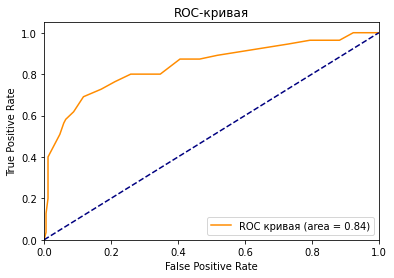

In [52]:
# рассчитываем ROC AUC
s = best_model_RandomForestClassifier_down.predict_proba(features_test)[:, 1]
lr_auc = roc_auc_score(target_test, s)
print('RandomForestClassifier_down: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, s)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ответим на вопрос о самых важных признаках, позволяющих спрогнозировать отток клиентов
fe = best_model_RandomForestClassifier_down.feature_importances_
list(zip(features_train.columns, fe))

In [ ]:
fe = best_model_RandomForestClassifier_up.feature_importances_
list(zip(features_train.columns, fe))

Выводы по разделу
1. Лучший результат получился на downsampling модели - 0.71. Что весьма приемлемо.
2. Значение ROC AUC=0.833. Это значение сильно превосходит 0,5. Что тоже можно признать удачным результатом
3. При уточнении моделей можно не использовать часть коэффициентов, как не влияющие на итоговый результат. При установлении границы влияния 5% можно смело вычеркнуть: EstimatedSalary, IsActiveMember, HasCrCard, Gender, Geography
4. Наиболее влияющие показатели это:
 - Age. Как и говорилось выше, возраст имеет высокую корреляцию с целевым показателем. Вероятно, надо более четко таргетироваться на разных возрастных группах.
 - Balance, EstimatedSalary. Можно предполодить, что чем меньше у человека зарплата и денег на счету, тем он менее заинтересован в услугах банка. Вероятно, надо пересмотреть услуги
 - Кредитный рейтинг. Надо более серьезно исследовать этот показатель.
 - NumOfProducts. Если банк не интересный и мало продуктов, то люди его меняют
 - Tenure. Можно сказать, привычка. Чем больше человек в банке, тем больше его все устраивает.
 
 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: задача исследована
    - [X]  Исследован баланс классов
    - [X]  Изучены модели без учёта дисбаланса
    - [X]  Написаны выводы по результатам исследования
- [X]  Выполнен шаг 3: учтён дисбаланс
    - [X]  Применено несколько способов борьбы с дисбалансом
    - [X]  Написаны выводы по результатам исследования
- [X]  Выполнен шаг 4: проведено тестирование
- [X]  Удалось достичь *F1*-меры не менее 0.59
- [X]  Исследована метрика *AUC-ROC*